# Liesel-GAM Demo Notebook

## Setup and Imports

In [1]:
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import numpy as np
import pandas as pd
import plotnine as p9
import tensorflow_probability.substrates.jax.distributions as tfd

import liesel_gam as gam

In [2]:
def gen_tp_data(n=400, noise_sd=0.3, grid=False, seed=1):
    """
    Generate test data for tensor-product smooths.

    Parameters
    ----------
    n : int
        Number of samples (if grid=False).
    noise_sd : float
        Standard deviation of Gaussian noise.
    grid : bool
        If True, generate approximately n points on a regular grid.
        If False, generate random design points.
    seed : int
        Random seed.

    Returns
    -------
    pandas.DataFrame with columns: x, y, eta (signal), z (noisy response)
    """
    rng = np.random.default_rng(seed)

    # --- Design ----
    if grid:
        m = int(np.ceil(np.sqrt(n)))
        xs = np.linspace(0, 1, m)
        ys = np.linspace(0, 1, m)
        x, y = np.meshgrid(xs, ys, indexing="xy")
        x = x.ravel()
        y = y.ravel()
    else:
        x = rng.uniform(0, 1, n)
        y = rng.uniform(0, 1, n)

    # --- True non-separable smooth ----
    def f_true(x, y):
        return (
            1.5 * np.sin(2 * np.pi * x) * np.cos(3 * np.pi * y)
            + 0.8 * x * y
            + 2.0 * np.exp(-(((x - 0.65) ** 2) / 0.01 + ((y - 0.35) ** 2) / 0.06))
        )

    eta = f_true(x, y)
    z = eta + rng.normal(scale=noise_sd, size=len(eta))

    return pd.DataFrame({"x": x, "y": y, "eta": eta, "z": z})

In [3]:
df = gen_tp_data(n=600, noise_sd=0.25, grid=False, seed=42)
print(df.head())

          x         y       eta         z
0  0.773956  0.477506  0.935849  0.689560
1  0.438878  0.761433  0.621075  0.405865
2  0.858598  0.903328  1.334100  1.948456
3  0.697368  0.720696 -0.674870 -0.224435
4  0.094177  0.963211 -0.714339 -0.817277


In [4]:
df_grid = gen_tp_data(n=5000, grid=True)

In [5]:
df_grid

,x,y,eta,z
0,0.000000,0.0,1.162528e-19,0.103675
1,0.014286,0.0,1.344590e-01,0.380944
2,0.028571,0.0,2.678353e-01,0.366966
3,0.042857,0.0,3.990553e-01,0.008108
4,0.057143,0.0,5.270622e-01,0.798669
...,...,...,...,...
5036,0.942857,1.0,1.281348e+00,1.076909
5037,0.957143,1.0,1.164770e+00,1.171729
5038,0.971429,1.0,1.044978e+00,1.027468
5039,0.985714,1.0,9.230304e-01,0.818835


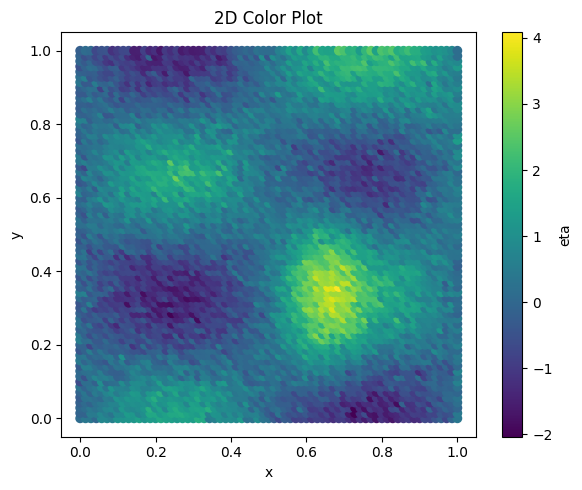

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.scatter(df_grid["x"], df_grid["y"], c=df_grid["z"])
plt.xlabel("x")
plt.ylabel("y")
plt.title("2D Color Plot")
plt.colorbar(label="eta")
plt.tight_layout()
plt.show()

## Model Definition

### Setup response model

In [7]:
loc = gam.AdditivePredictor("$\\mu$")
scale = gam.AdditivePredictor("$\\sigma$", inv_link=jnp.exp)


z = lsl.Var.new_obs(
    value=df.z.to_numpy(),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="z",
)

In [8]:
tb = gam.TermBuilder.from_df(df)

In [9]:
loc += tb.te("x", "y")

### Build and plot model

liesel.model.model - INFO - Converted dtype of Value(name="z_value").value


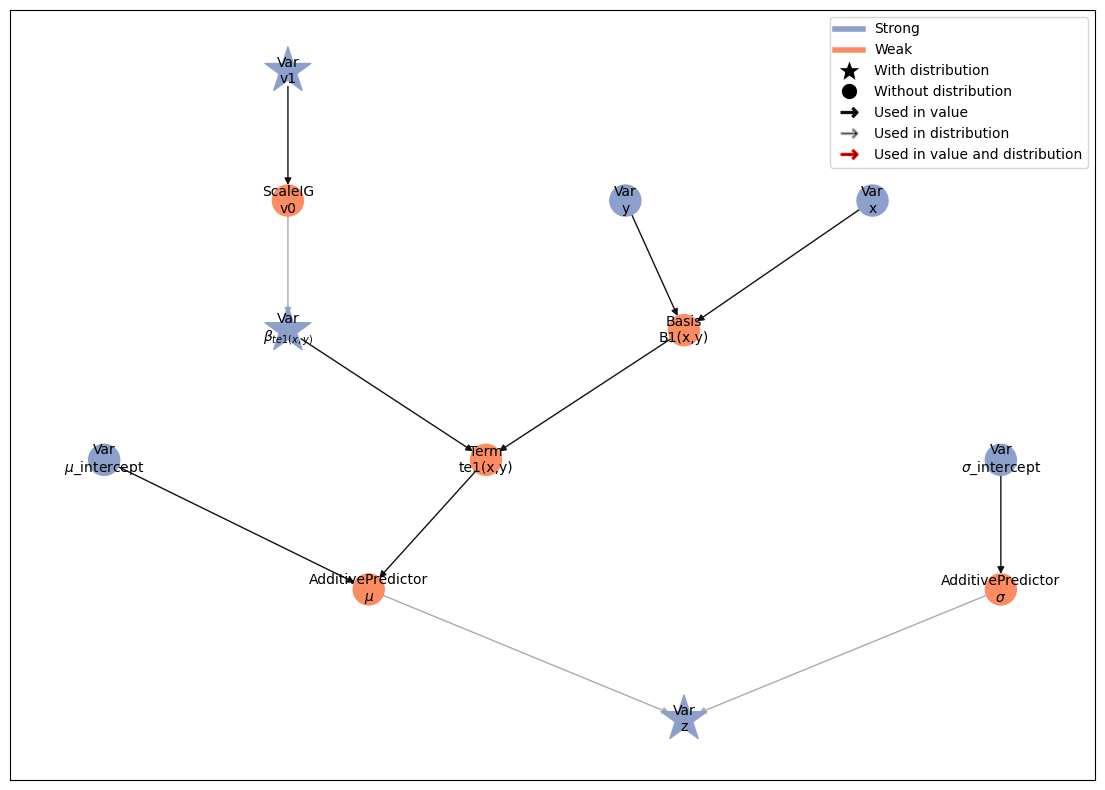

In [10]:
model = lsl.Model([z])
model.plot_vars()

## Run MCMC

Since we used the `inference` arguments to specify MCMC kernels for all parameters above,
we can quickly set up the MCMC engine with `gs.LieselMCMC` (new in v0.4.0).

In [11]:
eb = gs.LieselMCMC(model).get_engine_builder(
    seed=1, num_chains=4
)  # New in liesel v0.4.0

eb.set_epochs(
    gs.stan_epochs(
        warmup_duration=1000,
        posterior_duration=1000,
        init_duration=200,
        term_duration=200,
        thinning_posterior=5,
    )
)
engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys '$\\sigma$_intercept', '$\\mu$_intercept', '$\\beta_{te1(x,y)}$', 'v1'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 200 transitions, 25 jitted together
100%|██████████████████████████████████████████| 8/8 [00:02<00:00,  3.05chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|████████████████████████████████████████| 1/1 [00:00<00:00, 1278.75chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together
100%|████████████████████████████████████████| 2/2 [00:00<00:00, 1624.44chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoc

### MCMC summary

In [12]:
summary = gs.Summary(results)
summary

Parameter summary:

                             kernel      mean        sd    q_0.05     q_0.5  \
parameter          index                                                      
$\beta_{te1(x,y)}$ (0,)   kernel_02 -0.337060  0.189138 -0.635781 -0.332031   
                   (1,)   kernel_02 -0.587886  0.174569 -0.877059 -0.588157   
                   (2,)   kernel_02 -0.248863  0.213219 -0.602375 -0.248398   
                   (3,)   kernel_02 -0.286382  0.193009 -0.621367 -0.285260   
                   (4,)   kernel_02 -0.460237  0.172176 -0.756461 -0.455393   
...                             ...       ...       ...       ...       ...   
                   (61,)  kernel_02  0.370407  0.182736  0.077224  0.364576   
                   (62,)  kernel_02  0.416571  0.395501 -0.230440  0.437761   
$\mu$_intercept    ()     kernel_01  0.361637  0.011812  0.342047  0.361275   
$\sigma$_intercept ()     kernel_00 -1.247080  0.030405 -1.295576 -1.247653   
v1                 ()     kernel_03  1.117200  0.268823  0.753638  1.078083   

                            q_0.95  sample_size    ess_bulk    ess_tail  \
parameter          index                                                  
$\beta_{te1(x,y)}$ (0,)  -0.040077          800  309.459982  560.073816   
                   (1,)  -0.298587          800  263.129357  615.063700   
                   (2,)   0.092908          800  247.618824  489.912625   
                   (3,)   0.016724          800  256.308329  487.404632   
                   (4,)  -0.197099          800  268.789105  469.810976   
...                            ...          ...         ...         ...   
                   (61,)  0.669395          800  210.014805  261.058929   
                   (62,)  1.054919          800  275.489456  516.889862   
$\mu$_intercept    ()     0.380519          800  861.111837  771.346340   
$\sigma$_intercept ()    -1.197740          800  623.544464  715.611861   
v1                 ()     1.605903          800  395.721615  634.904586   

                              rhat  
parameter          index            
$\beta_{te1(x,y)}$ (0,)   1.005638  
                   (1,)   1.012508  
                   (2,)   0.999922  
                   (3,)   1.007252  
                   (4,)   1.006305  
...                            ...  
                   (61,)  1.015416  
                   (62,)  1.028298  
$\mu$_intercept    ()     0.998969  
$\sigma$_intercept ()     1.001169  
v1                 ()     1.007067  

[66 rows x 10 columns]

### MCMC trace plots

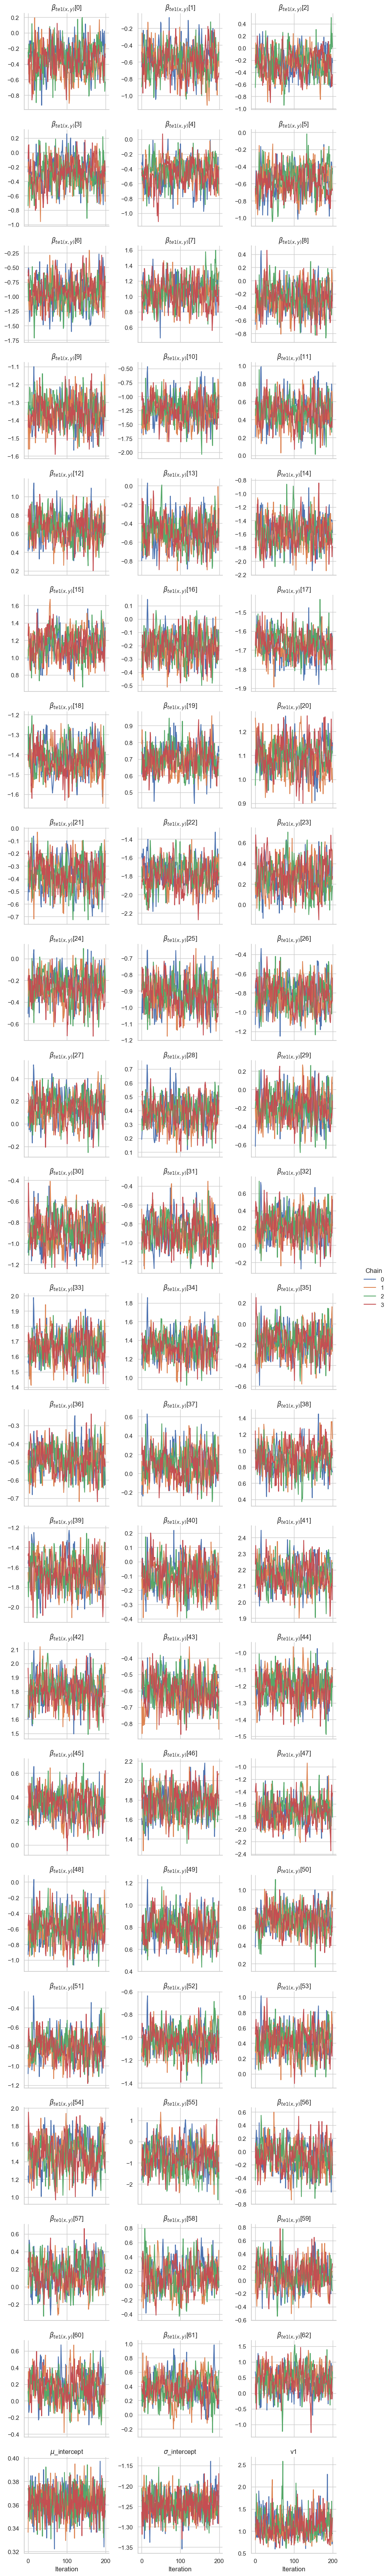

In [13]:
gs.plot_trace(results)

## Predictions

In [14]:
samples = results.get_posterior_samples()

### Predict variables at new x values

In [15]:
predictions = model.predict(  # new in liesel v0.4.0
    samples=samples,
    predict=["te1(x,y)", "$\\mu$"],
    newdata={"x": df_grid.x.to_numpy(), "y": df_grid.y.to_numpy()},
)

predictions_summary = (
    gs.SamplesSummary(predictions).to_dataframe().reset_index()
)  # new in liesel v0.4.0

In [16]:
predictions_summary["x"] = np.tile(df_grid.x.to_numpy(), len(predictions))
predictions_summary["y"] = np.tile(df_grid.y.to_numpy(), len(predictions))

In [17]:
predictions_summary.head()

,variable,var_fqn,var_index,sample_size,mean,var,sd,rhat,ess_bulk,ess_tail,mcse_mean,mcse_sd,q_0.05,q_0.5,q_0.95,hdi_low,hdi_high,x,y
0,$\mu$,$\mu$[0],"(0,)",800,0.754140,0.531201,0.728835,1.003347,361.334970,490.400259,0.038406,0.022336,-0.471142,0.750775,1.920830,-0.477881,1.903181,0.000000,0.0
1,$\mu$,$\mu$[1],"(1,)",800,0.793629,0.377838,0.614686,1.003183,359.880088,521.995921,0.032491,0.018695,-0.254116,0.791592,1.786020,-0.275354,1.764579,0.014286,0.0
2,$\mu$,$\mu$[2],"(2,)",800,0.844007,0.269622,0.519251,1.001750,355.537437,518.939189,0.027557,0.015782,-0.025466,0.834246,1.685622,0.003619,1.703379,0.028571,0.0
3,$\mu$,$\mu$[3],"(3,)",800,0.903915,0.193922,0.440366,1.001581,352.080617,500.595724,0.023484,0.013289,0.185493,0.908531,1.628225,0.196287,1.633885,0.042857,0.0
4,$\mu$,$\mu$[4],"(4,)",800,0.971368,0.140826,0.375268,1.002460,348.132870,472.367273,0.020121,0.011284,0.379395,0.973234,1.578342,0.380241,1.581924,0.057143,0.0


### Plot fitted functions

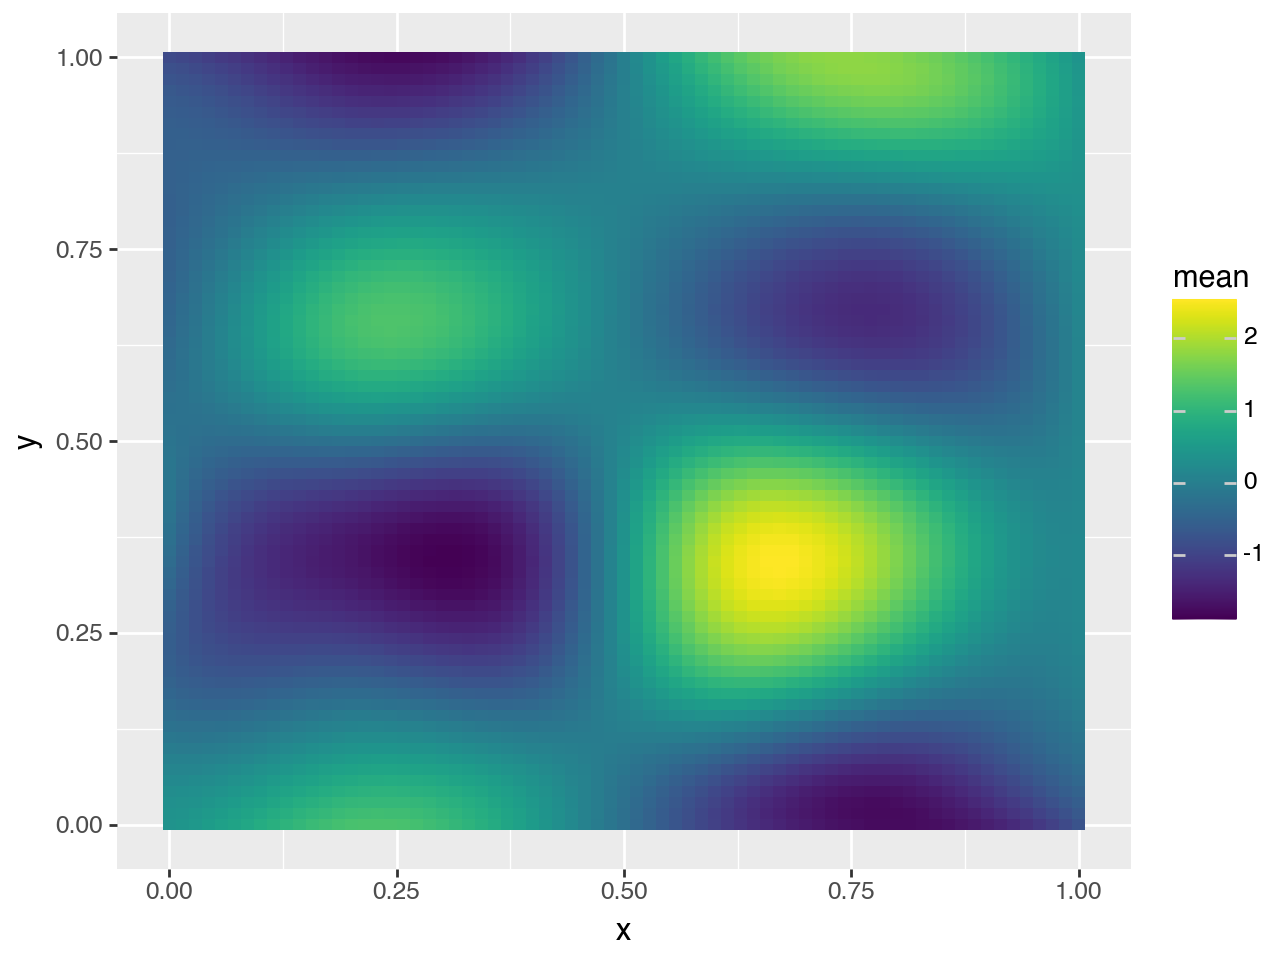

In [18]:
select = predictions_summary["variable"].isin(["te1(x,y)"])
(p9.ggplot(predictions_summary[select]) + p9.geom_tile(p9.aes("x", "y", fill="mean")))

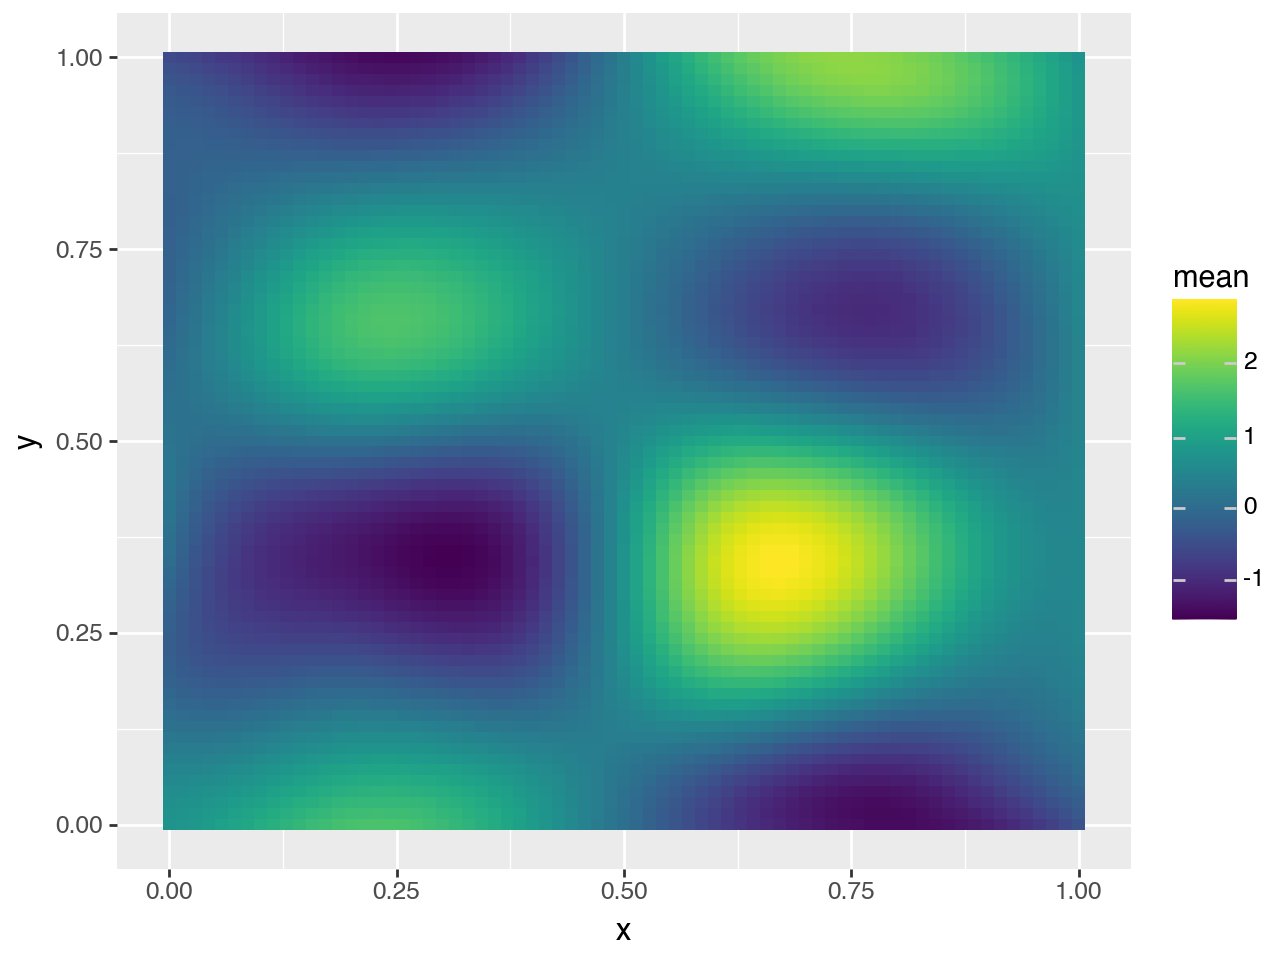

In [19]:
select = predictions_summary["variable"].isin(["$\\mu$"])
(p9.ggplot(predictions_summary[select]) + p9.geom_tile(p9.aes("x", "y", fill="mean")))

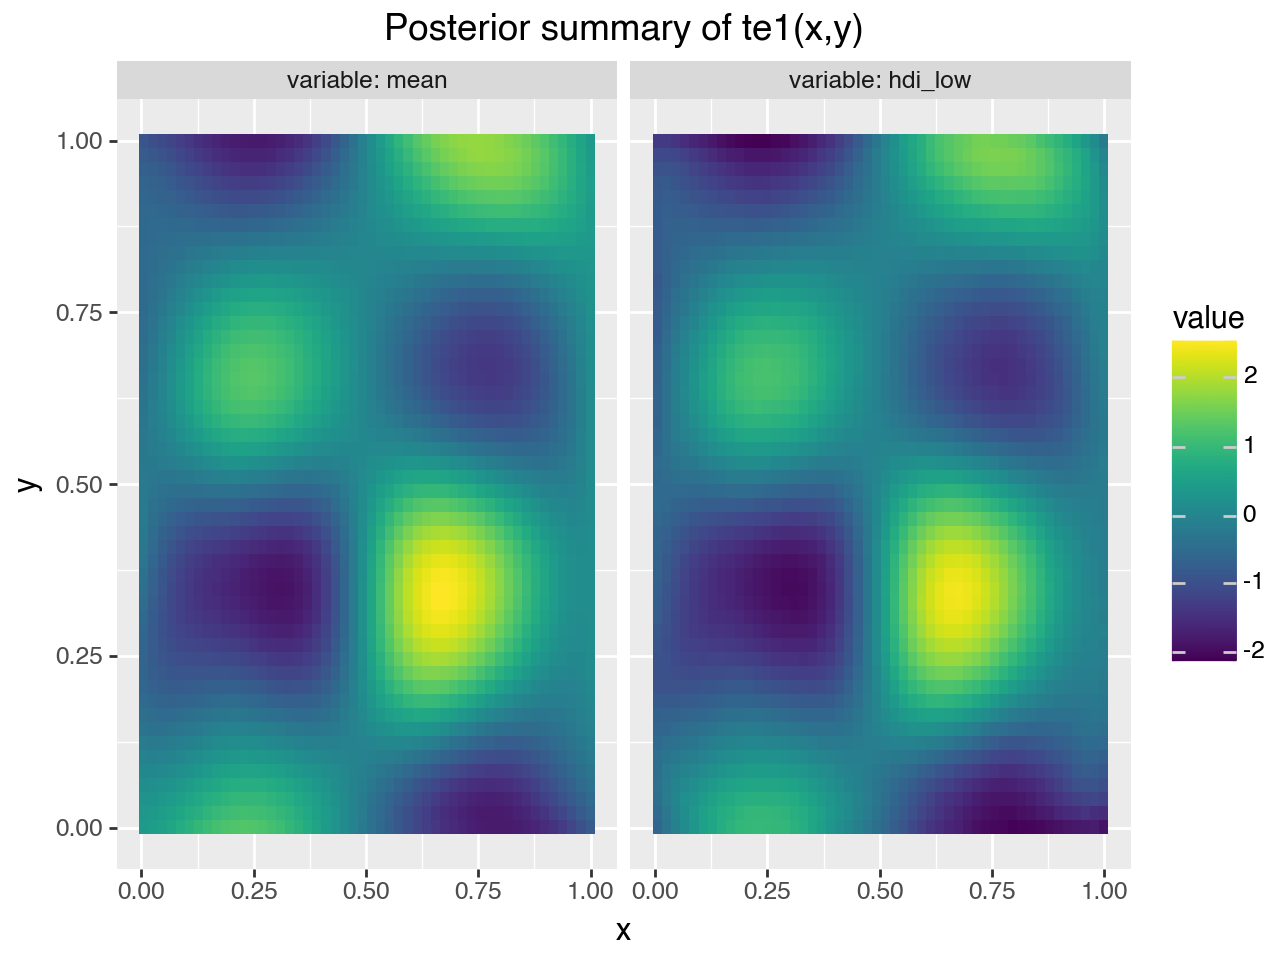

In [21]:
from liesel_gam.plots import plot_2d_smooth

plot_2d_smooth(
    loc.terms["te1(x,y)"], samples=samples, ngrid=50, plot_vars=["mean", "hdi_low"]
)